# Trying Out Discrete Flow Matching

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax
import optax
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
# Needed to debug flow of vector field
from jax import config
config.update("jax_enable_x64", False)

In [4]:
import dfm.loss_and_sample as las
import dfm.string_data as example_data
import dfm.training as training
import dfm.basic_model as models

## Main

### Training Loop

In [5]:
# Creating 100 corrupted versions of my name
reference = "elisroberts"
data = example_data.StringDataset(reference, 100, 0.15)

In [6]:
# Initialize model
model = models.MultipleMLP(data.num_cats)
example_input = jnp.ones((data.d, data.num_cats))

variables = model.init(jr.PRNGKey(0), example_input, 1.0)
params = variables["params"]

In [7]:
optim = optax.adam(5e-3)
opt_state = optim.init(params)

In [8]:
batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

In [9]:
NUM_EPOCHS = 200
losses = []
key = jr.PRNGKey(0)
t_infty = 8.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for i, x_batch in enumerate(dataloader):
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, t_infty, key=subkey)
        epoch_loss += loss
    avg_loss = epoch_loss / (i + 1)  # Approximate since batches not common divisor of dataset size
    losses.append(avg_loss)
    pbar.set_description(f"Loss: {avg_loss:.2f}")

losses = jnp.array(losses)

Loss: 0.28: 100%|██████████| 200/200 [00:08<00:00, 23.37it/s]


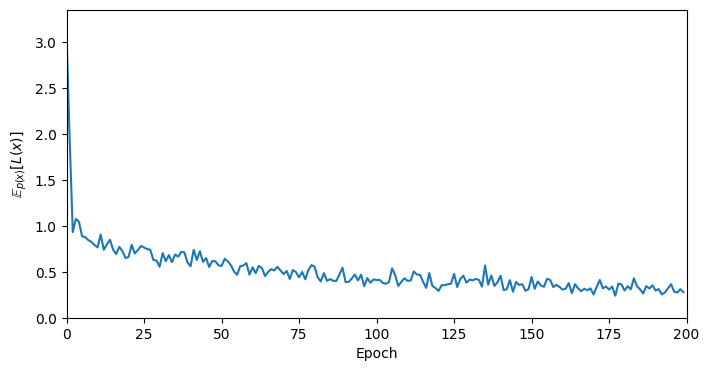

In [10]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

### Inference

In [11]:
sample_key = jr.PRNGKey(5)
steps = 100
t_infty = t_infty
output, xs_output = las.sample(params, model, t_infty, steps, shape=(data.d,), key=sample_key)
sampled_name = example_data.detokenize_string(output)
sampled_name

'elisroberts'

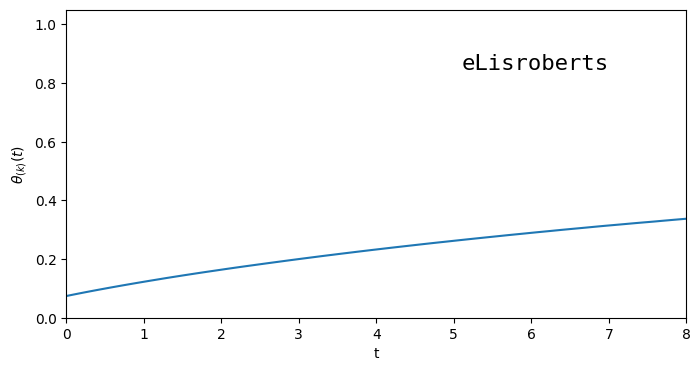

In [12]:
pos = 1
letter = example_data.tokenize_string(reference[pos])
reference_alt = reference[:pos] + reference[pos].upper() + reference[pos + 1:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(jnp.linspace(0.0, t_infty, num=steps + 1), xs_output[:, pos, letter])

_ = ax.text(int(0.95 * t_infty), 0.9, reference_alt, fontsize=16, ha="right", va="top", color="k", fontfamily="monospace")

_ = ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\theta_{(k)}(t)$")
_ = ax.set_xlim(0, t_infty)
_ = ax.set_ylim(0, 1.05)

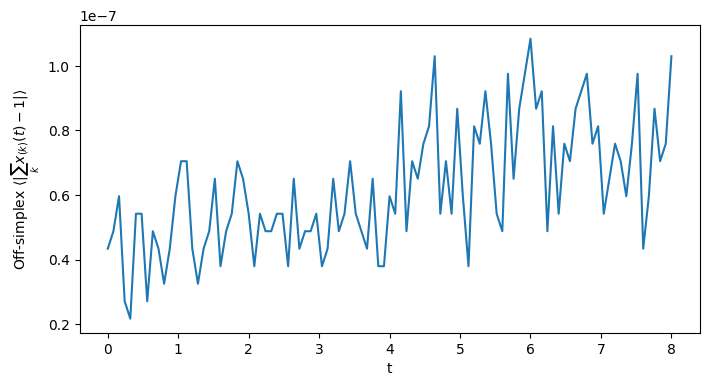

In [13]:
# Plot the error to show how off-simplex the final result is
errors = jnp.mean(jnp.abs(jnp.sum(xs_output, axis=-1) - 1.0), axis=-1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(jnp.linspace(0.0, t_infty, num=steps + 1), errors)

_ = ax.set_xlabel("t")
_ = ax.set_ylabel(r"Off-simplex $\langle |\sum_k x_{(k)}(t) - 1| \rangle$")

/Users/e.roberts/anaconda3/envs/dfm/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/Users/e.roberts/anaconda3/envs/dfm/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:2608: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/e.roberts/anaconda3/envs/dfm/lib/python3.12/site-packages/jax/_src/n

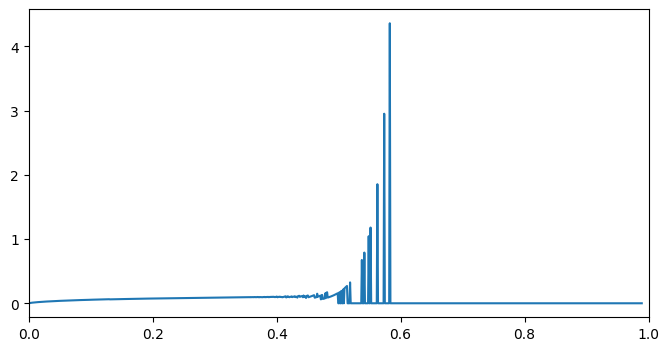

In [14]:
x_is = jnp.repeat(jnp.expand_dims(jnp.linspace(0.0, 1.0, num=1000, dtype=jnp.float64), axis=-1), 20, axis=-1)

t_coeffs = 1.0
coeffs = las.conditional_dirichlet_flow_coeff(x_is, t_coeffs)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_is[:, 0], coeffs[:, 0] + 0 * jnp.log1p(- x_is[:, 0]))

# _ = ax.set_ylim(0, 0.2)
_ = ax.set_xlim(0, 1)

$$\partial_t I_x(t + 1, b) B(t + 1, K - 1) = B(t + 1, K - 1) [\frac{1}{B(t + 1, K - 1)} \partial_t B(x; t + 1, K - 1) + B(x; t + 1, K - 1) \partial_t \frac{1}{B(t + 1, K - 1)}]$$

$$ = \partial_t B(x; t + 1, K - 1) - B(x; t + 1, K - 1) \partial_t \log B(t + 1, K - 1)$$

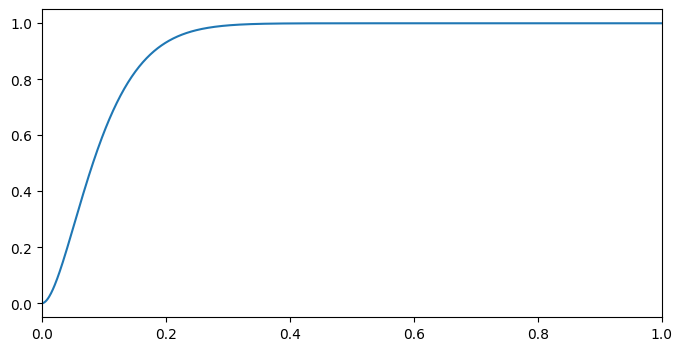

In [15]:
x_is = jnp.repeat(jnp.expand_dims(jnp.linspace(0.0, 1.0, num=1000, dtype=jnp.float64), axis=-1), 20, axis=-1)

t_coeffs = 1.0
coeffs = las.betainc(t_coeffs + 1, x_is.shape[-1] - 1, x_is)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_is[:, 0], coeffs[:, 0])

# _ = ax.set_ylim(0, 0.2)
_ = ax.set_xlim(0, 1)

/var/folders/wk/9kvs_kgd7rq4r04wgzcd_18h0000gn/T/ipykernel_88356/3964083197.py:21: RuntimeWarning: invalid value encountered in multiply
  final = interp * out


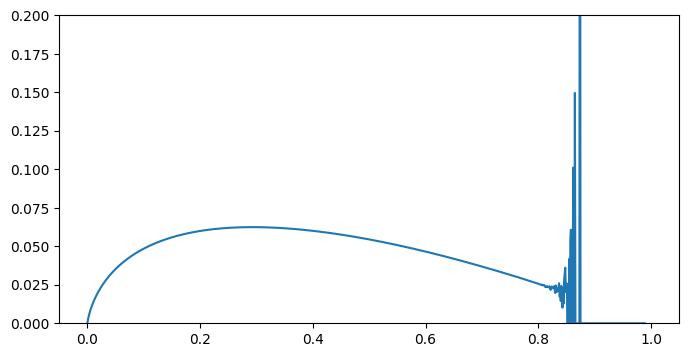

In [16]:
import numpy as np
import scipy

class DirichletConditionalFlow:
    def __init__(self, K=20, alpha_min=1, alpha_max=100, alpha_spacing=0.01):
        self.alphas = np.arange(alpha_min, alpha_max + alpha_spacing, alpha_spacing)
        self.beta_cdfs = []
        self.bs = np.linspace(0, 1, 1000)
        for alph in self.alphas:
            self.beta_cdfs.append(scipy.special.betainc(alph, K-1, self.bs))
        self.beta_cdfs = np.array(self.beta_cdfs)
        self.beta_cdfs_derivative = np.diff(self.beta_cdfs, axis=0) / alpha_spacing
        self.K = K

    def c_factor(self, bs, alpha):
        out1 = scipy.special.beta(alpha, self.K - 1)
        out2 = np.where(bs < 1, out1 / ((1 - bs) ** (self.K - 1)), 0)
        out = np.where(bs > 0, out2 / (bs ** (alpha - 1)), 0)
        I_func = self.beta_cdfs_derivative[np.argmin(np.abs(alpha - self.alphas))]
        interp = -np.interp(bs, self.bs, I_func)
        final = interp * out
        return final

dcf = DirichletConditionalFlow()
coeffs = dcf.c_factor(x_is[:, 0], 2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_is[:, 0], coeffs * (1 - x_is[:, 0]))

_ = ax.set_ylim(0, 0.2)

In [17]:
num_cats = x_is.shape[-1]
beta_inc_diff = (
    las.betainc(t_coeffs + 1 + las.GRAD_ESTIMATOR / 2, num_cats - 1, x_is) - las.betainc(t_coeffs + 1 - las.GRAD_ESTIMATOR / 2, num_cats - 1, x_is)
) / las.GRAD_ESTIMATOR